# <center> PHY68 Project 1: Projectile Free Fall Modeling </center>
### <center> By [Name Omitted], Won Kim, Daniel Opara </center>
### <center> February 7, 2023 </center>

##**Intro to Discretization**




In introductory physics courses, most—if not all—of the equations we deal with are continuous. They allow us to quickly obtain solutions from closed form equations, which are equations that have a set number of basic operations which typically don't include limits, differentiation, or integration. However, in more advanced physics, finding a numerical solution to a problem becomes increasingly harder when given a complex equation. This is where discretization comes in, as it converts a continuous complex equation into a form that can
be used to calculate numerical solutions. In this project, we explore the process of discretization in modeling trajectory of the ball as it is dropped from a height of one meter using three methods and interpret the results: <br>
1) An analytical solution based on Newton's Seconds Law—which incorperates air resistance <br>
2) Euler's method (forward) <br>
3) Backward Euler's method <br>
4) Bashforth-Adams Method 

### Library Imports

This is where we imported the libraries needed for plotting and numerical work.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.interpolate
import csv
from scipy.optimize import fsolve

### Parameter Set-Up For Calculations

This is where we set up all the variables needed later for the calculation of our simulated models.

In [ ]:
g = 10 # Gravity constant in (metres per second sq.)
rho = 1.225 # Density of air
Cd = 0.5 # Coefficient of Drag for Ping Pong Ball
A = 4/2 * np.pi * (0.02)**2 # Cross-Sectional area of Ping Pong Ball
k = 1/2 * A * rho * Cd # Combining A, rho, and Cd into one constant k
m = 0.0027 # Mass of Ping Pong Ball in kg

y0 = 1 # Initial Height of Ping Pong Ball (in metres), positive means upwards
v0 = 0 # Initial Velocity of Ping Pong Ball (in metres per second)
t0 = 0 # Initial Time (in s)
vt = np.sqrt(m * g / k) # Terminal Velocity of Ping Pong Ball

dt = 0.01 # Time Resolution
tf = 2 # Total Time to Simulate

columns = ["t", "y"]
df = pd.read_csv("Data.csv", usecols=columns) # Importing and reading-in experimental data

nsteps = int(tf/dt) + 1 # Number of steps for computational solutions, note that we take the integer part

In [ ]:
t = np.linspace(t0,tf,nsteps) # Define t

v_Euler = np.zeros([nsteps]) # Set-up velocity/position lists for Euler's Method
y_Euler = np.zeros([nsteps])

v_Euler4 = np.zeros([nsteps]) # Set-up velocity/position lists for Backward Euler's Method
y_Euler4 = np.zeros([nsteps])

v_BA = np.zeros([nsteps]) # Set-up velocity/position lists for Bashforth-Adams Method
y_BA = np.zeros([nsteps])

###**Derivation of Analytical Solution**

The following code shows our analytical solution, which represents the motion of a ping pong ball in free fall with air resistance factored in. The derivation is shown below for $v(t)$:

$F = ma$

$-mg + cv^2 = m \dfrac{dv}{dt}$

$\dfrac{dv}{dt} = -g + \dfrac{c}{m}v^2$

$\dfrac{dv}{dt} = -g(1 - \dfrac{c}{mg}v^2)$

$\dfrac{dv}{dt} = -g(1 - \dfrac{v^2}{v_T^2})$ because $v_T^2 = \dfrac{mg}{c}$

$\int \dfrac{1}{1 - \frac{v^2}{v_T^2}} \,dv = \int -g \,dt$

$v_T \tanh^{-1}(\dfrac{v}{v_T}) = -gt + C$ where $C = v_0$

$v(t) = v_0 - v_T \tanh(\dfrac{g}{v_T}t)$

Then for $y(t)$:

$v = -v_T \dfrac{\sinh(\frac{g}{v_T}t)}{\cosh(\frac{g}{v_T}t)}$

$y(t) = -\dfrac{v_T^2}{g} \ln(\cosh(\dfrac{g}{v_T}t)) + C$ where $C = y_0$

$y(t) = y_0 -\dfrac{v_T^2}{g} \ln(\cosh(\dfrac{g}{v_T}t))$


In [ ]:
y_analytical = y0 - vt**2 / g * np.log(np.cosh(g * t / vt)) # Analytical Solution for y-Position

v_analytical = v0 - vt * np.tanh(g * t / vt) # Analytical Solution for Velocity

### Implementation of Approximations (Euler, Backward Euler, Bashforth-Adams)

We now present the main loops, where the velocity and y-position of the particle is updated in a stepwise manner using the Euler, Backward Euler, and Bashforth-Adams methods. While the Euler Method was relatively simple to implement, the Backward Euler method was more difficult due its neccesity of an estimated value for a future velocity. This was accomplished by using the `fsolve` function included in the SciPy library, which returns the root of non-linear equations if given a starting estimate. As for the Bashforth-Adams Method, it was fairly simple to implement as soon as the formula was understood, which is simply a modified version of the Euler Method.

In [ ]:
# Euler Method
y_Euler[0] = y0
v_Euler[0] = v0
for i in range(0,nsteps-1):
    v_Euler[i+1] = v_Euler[i] - dt * (g - (k / m) * v_Euler[i]**2)
    y_Euler[i+1] = y_Euler[i] + dt * v_Euler[i]

# Backward Euler Method using new velocity (Problem 4)
y_Euler4[0] = y0
v_Euler4[0] = v0

def backward_eulers_helper(yp, yo):
    value = yp - yo + dt * (g - (k / m) * yp**2)
    return value

for i in range(0,nsteps-1):
    yo = v_Euler4[i]
    yp = v_Euler4[i+1]
    yp = fsolve(backward_eulers_helper, yp, args = (yo))
    
    v_Euler4[i+1] = yp

    y_Euler4[i+1] = y_Euler4[i] + dt * v_Euler4[i+1]

# Bashforth-Adams Method
y_BA[0] = y0
v_BA[0] = v0
y_BA[1] = y_analytical[1]
v_BA[1] = v_analytical[1]
for i in range(1,nsteps-1):
    v_BA[i+1] = v_BA[i] - 1.5 * dt * (g - (k / m) * v_BA[i]**2) + 0.5 * dt * (g - (k / m) * v_BA[i-1]**2)
    y_BA[i+1] = y_BA[i] + 1.5 * dt * v_BA[i] - 0.5 * dt * v_BA[i-1]

###**Results**

Below are the graphs for our five methods of modeling the position of a ping pong ball dropped from a height of 1 meter:

Experimental: Our graph for this is the most non-smooth, as it is created using actual data points that track position vs time. This was collected using Tracker and digitized using the pandas library. The experimental results are compared to the other models as a measure of how accuraate they are in modeling real-life data given a few parameters of the scenario in question.

Analytical: This graph uses the derived equation for free-fall with air resistance. This was also used as a basis for error evaluation because we were only able to get 15 points with the experimental method while the other models have 201 points.

Euler: This graph uses the Euler Method, where we approximated the position of the particle using its prevous position value.

Backward Euler: This is the graph we found using the Backward Euler Method, where we approximated the next data point using both the previous and future points (through the fsolve function mentioned above).

Bashforth-Adams: This is the graph we found using the Bashforth-Adams Method, where we approximate the next data point using more than one previous points, leading to a more accurate result when compared to the analytical method.

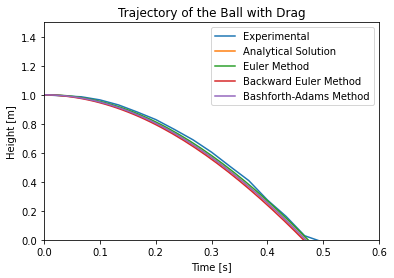

In [ ]:
plt.plot(df.t, df.y, label="Experimental")
plt.plot(t,y_analytical, label="Analytical Solution")
plt.plot(t,y_Euler, label="Euler Method")
plt.plot(t,y_Euler4, label="Backward Euler Method")
plt.plot(t,y_BA, label="Bashforth-Adams Method")
plt.legend()
plt.title('Trajectory of the Ball with Drag')
plt.xlabel('Time [s]')
plt.ylabel('Height [m]')
plt.ylim(0,1.5)
plt.xlim(0,0.6)
plt.show()

### Error Graphs and Error Analysis

We then created a graph to figure out the error over time for the Euler, Backward Euler, and Bashforth-Adams methods relative to the analytical solution. As you can see, the Bashforth-Adams method is by far the most accurate, as on this scale, it seems to have almost 0 error when compared to the analytical solution. Meanwhile, the Euler and Backward Euler methods seem to have the same amount of error, but with one overestimating the position of the ball and one underestimating the position of the ball. This is consistent with what we know about these two methods, as they should have the same magnitude in terms of accuracy.

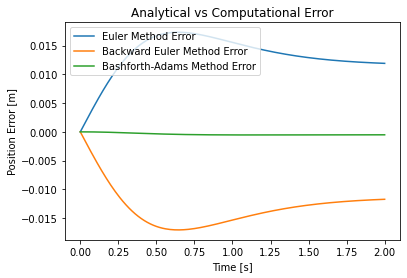

In [ ]:
# Calculating error compared to analytical solution
error_Euler = y_Euler - y_analytical
error_Euler4 = y_Euler4 - y_analytical
error_BA = y_BA - y_analytical

plt.plot(t,error_Euler, label="Euler Method Error")
plt.plot(t,error_Euler4, label="Backward Euler Method Error")
plt.plot(t,error_BA, label="Bashforth-Adams Method Error") # looks like zero compared to Euler error, but true plot below
plt.title('Analytical vs Computational Error')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Position Error [m]')
plt.show()

### Bashforth-Adams Error Graph

We decided to plot the Bashforth-Adams method in its own separate graph because we weren't able to clearly see its error when we compared it to the Euler and Backward Euler method as shown in the graph above. By zooming in, we can see that there is indeed an error from the analytical solution, but it is at a miniscule magnitude and the method seems to correct itself after it had drifted off too much, resulting in it curving around the middle.

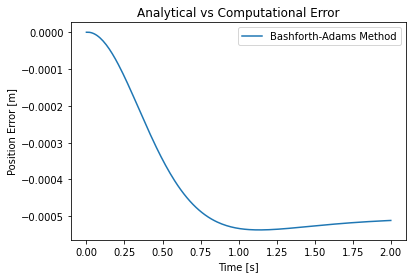

In [ ]:
# Bashforth-Adams error plot 
plt.plot(t, error_BA, label="Bashforth-Adams Method")
plt.title('Analytical vs Computational Error')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Position Error [m]')
plt.show()

###**Discussion**

As seen from above, the Bashforth-Adams method proved to be the most accurate in modeling the trajectory of a ball. Although this method is superior to the other two Euler methods used to model this situation, it must be noted that the two Euler methods and the Bashforth-Adams method had their error curves generated by comparing their results to that of the analytical solution. The analytical solution does a good job in modeling the trajectory of a ping ball in free fall quite well, it fails to capture other variables of the experiment that may have affected the trajectory of the ball such as the manner in which it was dropped, whether there was a bit of spin to the ball, etc. Albeit there many variables in this experiment that were negligible, comparing the models used in this project to experimental data rather than an analytical solution would yield more accurate error graphs. Unfortunatly, this was not possible due to the lack of data points for experimental data compared to the data generated through our models. Additionally, using SciPy to interpolate the small dataset to make it big enough to compare to the model proved to unsuccessful and made the error graphs seem inaccuate.

**Conclusion**

The aim of this project was utilize discretization to model the trajectory of a ping pong ball in free fall. Overall, this task was done successfully and the models generated support the experimental data collected. If time allowed it, future iterations of this experiment would include figuring out a method to collect more data points from a object that is being tracked. The limited size of our experimental data was due to the software used since it required that a user manually examines frames to use for create position vs time plots. Having a tracker to automatically take care of this would aid in comparing experimental results to models generated to represent the scenario in question. In addition to this, introducing another method used by many of our peers may have provided less error in modeling the ping pong ball's trajectory. In particular, the Runge–Kutta method was known to produce very accurate results since uses four weights to approximate its estimate.